# Basics: overfitting a MLP on CIFAR10

# CIFAR-10 dataset

In this notebook, we use the CIFAR-10 dataset made of images from 10 classes: plane, car, bird, cat, deer, dog, frog, horse, ship, and truck. The images are all of the same size with $3\times 32\times 32$ pixels. The first channel is used for the RGB description of the image with the 2 others are the X and Y position of a pixel.

1. What is the machine learning family this problem is about? What is the nature of the input data?

2. Enumerate some methods that could be used for such a task.

3. We separate the dataset into two parts: train and test. Remind what they are used for.

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as t
import matplotlib.pyplot as plt
import numpy as np

# load data
to_tensor =  t.ToTensor()
normalize = t.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
flatten =  t.Lambda(lambda x:x.view(-1))

transform_list = t.Compose([to_tensor, normalize, flatten])
train_set = torchvision.datasets.CIFAR10(root='.', train=True, transform=transform_list, download=True)
test_set = torchvision.datasets.CIFAR10(root='.', train=False, transform=transform_list, download=True)

train_loader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


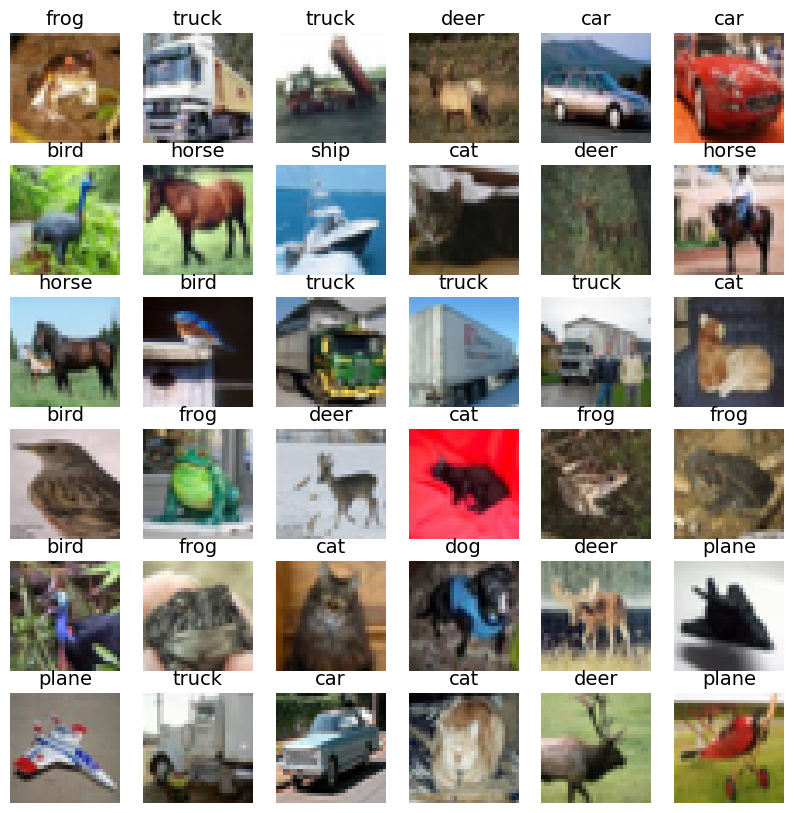

In [ ]:
# Plot some images
nx = 6
ny = 6
fig, ax = plt.subplots(nx, ny, figsize=(10,10))
for i in range(nx):
  for j in range(ny):
    ax[i][j].imshow(train_set.data[i*nx+j])
    ax[i][j].axis('off')
    ax[i][j].set_title(classes[train_set.targets[i*nx+j]],
                       fontsize=14)

[5000 5000 5000 5000 5000 5000 5000 5000 5000 5000]
[1000 1000 1000 1000 1000 1000 1000 1000 1000 1000]


Text(0.5, 1.0, 'Proportion test set')

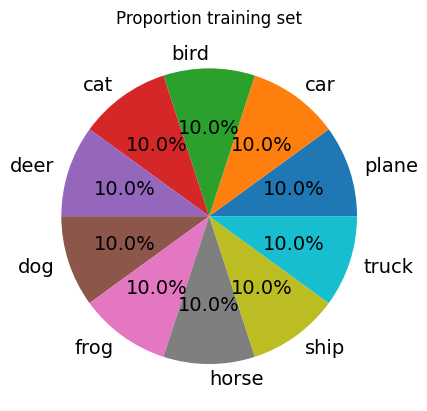

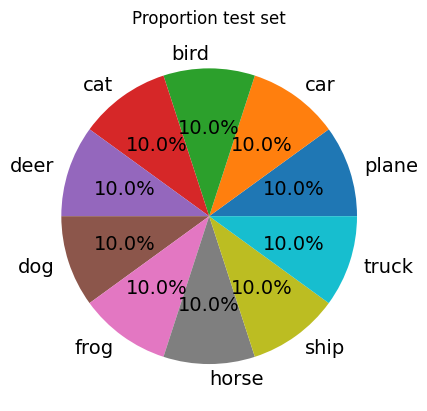

In [ ]:
# Your code to check the proportions of images in each class

# Proportion training set
_, counts_train = np.unique(train_set.targets, return_counts=True)

print(counts_train)
fig, ax = plt.subplots()
_ = ax.pie(counts_train, labels=classes, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title(r'Proportion training set')

# Proportion test set
_, counts_test = np.unique(test_set.targets, return_counts=True)

print(counts_test)
fig, ax = plt.subplots()
_ = ax.pie(counts_test, labels=classes, autopct='%1.1f%%', textprops={'fontsize': 14})
ax.set_title(r'Proportion test set')

# Training loop

The basic network is a small neural network made of one layer with 1000 neurons.

4. Draw the diagram of the networks declared in the code below. How many parameters does it have?

The model is specified for you. Now you have to train it on the training data using the backpropagation algorithm and stochastic gradient descent.

5. Remind how SGD works.

6. Specify a loss function and an optimization procedure. In our case, we'll use the [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) together with the [SGD optimizer](https://pytorch.org/docs/stable/generated/torch.optim.SGD.html). Set the learning rate to 0.01 and the momentum to 0.9.


In [ ]:
# define network structure
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)

# === Train === ###
net.train()

# train loop
for epoch in range(3):
    train_correct = 0
    train_loss = 0
    print('Epoch {}'.format(epoch))

    # loop per epoch
    for i, (batch, targets) in enumerate(train_loader):

        output = net(batch)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        train_correct += pred.eq(targets.view_as(pred)).sum().item()
        train_loss += loss

        if i % 100 == 10: print('Train loss {:.4f}, Train accuracy {:.2f}%'.format(
            train_loss / (i * 64), 100 * train_correct / (i * 64)))

print('End of training.\n')

# === Test === ###
test_correct = 0
net.eval()

# loop, over whole test set
for i, (batch, targets) in enumerate(test_loader):

    output = net(batch)
    pred = output.max(1, keepdim=True)[1]
    test_correct += pred.eq(targets.view_as(pred)).sum().item()

print('End of testing. Test accuracy {:.2f}%'.format(
    100 * test_correct / (len(test_loader) * 64)))

In [ ]:
n_param_tot = 0
for parameter in net.parameters():
  n_param_tot += np.prod(parameter.shape)

print(n_param_tot)
print(3072*1000+1000+10*1000+10)

3083010
3083010


Training loop over CIFAR10 (40,000 train images, 10,000 test images). What happens if you
- switch the training to a GPU? Is it faster?
- Remove the `ReLU()`?
- Increase the learning rate?
- Stack more layers?
- Perform more epochs?

Can you completely overfit the training set (i.e. get 100% accuracy?)

This code is highly non-modulable. Create functions for each specific task.
(hint: see [this](https://github.com/pytorch/examples/blob/master/mnist/main.py))

Your training went well. Good. Why not save the weights of the network (`net.state_dict()`) using `torch.save()`?

7. Create a function `train` and `test`.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
def train(model, device, train_loader, criterion, optimizer, epoch):
    model.train()
    print('Epoch {}'.format(epoch))
    train_correct = 0
    train_loss = 0
    train_l = 0
    # loop per epoch
    for i, (batch, targets) in enumerate(train_loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        targets = targets.to(device)

        output = model(batch)
        loss = criterion(output, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        pred = output.max(1, keepdim=True)[1]
        train_correct += pred.eq(targets.view_as(pred)).sum().item()
        train_loss += loss.item()
        train_l += bs

        if i % 100 == 10: print('Train loss {:.4f}, Train accuracy {:.2f}%'.format(
            train_loss / train_l, 100 * train_correct / train_l))


In [ ]:
def test(model, device, test_loader):
    model.eval()
    test_correct = 0
    test_l =0
    for i, (batch, targets) in enumerate(test_loader):
        bs = batch.shape[0]
        batch = batch.to(device)
        targets = targets.to(device)
        output = model(batch)
        pred = output.max(1, keepdim=True)[1]
        test_correct += pred.eq(targets.view_as(pred)).sum().item()
        test_l += bs

    print('End of testing. Test accuracy {:.2f}%'.format(
    100 * test_correct / test_l))

8. Train a model on the CPU and one on on the GPU. Compare the running times.

In [ ]:
device = 'cpu'
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

In [ ]:
%%time
train(net,device,train_loader,criterion,optimizer,1)

Epoch 1
Train loss 0.0345, Train accuracy 19.32%
Train loss 0.0295, Train accuracy 32.70%
Train loss 0.0282, Train accuracy 36.37%
Train loss 0.0274, Train accuracy 38.16%
Train loss 0.0267, Train accuracy 39.78%
Train loss 0.0263, Train accuracy 40.59%
Train loss 0.0261, Train accuracy 41.20%
Train loss 0.0258, Train accuracy 41.82%
CPU times: user 37.6 s, sys: 144 ms, total: 37.7 s
Wall time: 38.8 s


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

In [ ]:
%%time
train(net,device,train_loader,criterion,optimizer,1)

Epoch 1
Train loss 0.0346, Train accuracy 18.47%
Train loss 0.0295, Train accuracy 32.67%
Train loss 0.0282, Train accuracy 36.43%
Train loss 0.0274, Train accuracy 38.26%
Train loss 0.0267, Train accuracy 39.79%
Train loss 0.0263, Train accuracy 40.52%
Train loss 0.0261, Train accuracy 41.21%
Train loss 0.0258, Train accuracy 41.82%
CPU times: user 35.1 s, sys: 58 ms, total: 35.1 s
Wall time: 36 s


9. Remove the ReLU activation. What becomes the network in this case? Compute and comments the performances.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

for i in range(3):
    train(net,device,train_loader,criterion,optimizer,i)
    test(net,device,test_loader)

Epoch 0
Train loss 0.0346, Train accuracy 19.60%
Train loss 0.0295, Train accuracy 32.98%
Train loss 0.0282, Train accuracy 36.40%
Train loss 0.0274, Train accuracy 38.23%
Train loss 0.0267, Train accuracy 39.85%
Train loss 0.0263, Train accuracy 40.68%
Train loss 0.0260, Train accuracy 41.43%
Train loss 0.0258, Train accuracy 42.00%
End of testing. Test accuracy 48.00%
Epoch 1
Train loss 0.0230, Train accuracy 48.86%
Train loss 0.0230, Train accuracy 49.09%
Train loss 0.0229, Train accuracy 48.76%
Train loss 0.0228, Train accuracy 49.13%
Train loss 0.0226, Train accuracy 49.54%
Train loss 0.0225, Train accuracy 49.67%
Train loss 0.0224, Train accuracy 49.81%
Train loss 0.0224, Train accuracy 49.93%
End of testing. Test accuracy 49.72%
Epoch 2
Train loss 0.0210, Train accuracy 54.26%
Train loss 0.0212, Train accuracy 52.86%
Train loss 0.0212, Train accuracy 52.84%
Train loss 0.0211, Train accuracy 53.24%
Train loss 0.0209, Train accuracy 53.54%
Train loss 0.0209, Train accuracy 53.59%


In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

for i in range(3):
    train(net,device,train_loader,criterion,optimizer,i)
    test(net,device,test_loader)

Epoch 0
Train loss 0.0334, Train accuracy 22.30%
Train loss 0.0301, Train accuracy 32.38%
Train loss 0.0296, Train accuracy 34.12%
Train loss 0.0292, Train accuracy 34.63%
Train loss 0.0288, Train accuracy 35.68%
Train loss 0.0287, Train accuracy 35.93%
Train loss 0.0286, Train accuracy 36.26%
Train loss 0.0285, Train accuracy 36.36%
End of testing. Test accuracy 38.81%
Epoch 1
Train loss 0.0267, Train accuracy 39.06%
Train loss 0.0272, Train accuracy 39.46%
Train loss 0.0275, Train accuracy 39.07%
Train loss 0.0275, Train accuracy 38.87%
Train loss 0.0274, Train accuracy 39.30%
Train loss 0.0274, Train accuracy 39.20%
Train loss 0.0274, Train accuracy 39.30%
Train loss 0.0274, Train accuracy 39.21%
End of testing. Test accuracy 39.02%
Epoch 2
Train loss 0.0264, Train accuracy 41.05%
Train loss 0.0269, Train accuracy 40.70%
Train loss 0.0272, Train accuracy 39.99%
Train loss 0.0272, Train accuracy 39.89%
Train loss 0.0271, Train accuracy 40.25%
Train loss 0.0271, Train accuracy 40.14%


10. Change the learning rate. Comment.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(nn.Linear(3 * 32 * 32, 1000), nn.ReLU(), nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.1, momentum=0.9)
net = net.to(device)

for i in range(1):
    train(net,device,train_loader,criterion,optimizer,i)
    test(net,device,test_loader)

Epoch 0
Train loss 0.0342, Train accuracy 22.73%
Train loss 0.2320, Train accuracy 22.58%
Train loss 7.4938, Train accuracy 20.96%
Train loss 321.0443, Train accuracy 20.28%
Train loss 10331.5943, Train accuracy 20.43%
Train loss 436773.5373, Train accuracy 20.25%
Train loss 16117542.1515, Train accuracy 20.18%
Train loss 638806285.0275, Train accuracy 20.14%
End of testing. Test accuracy 21.16%


11. Add more layers. Comment.

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = nn.Sequential(
    nn.Linear(3 * 32 * 32, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 1000),
    nn.ReLU(),
    nn.Linear(1000, 10))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(net.parameters(), lr = 0.01, momentum=0.9)
net = net.to(device)

for i in range(5):
    train(net,device,train_loader,criterion,optimizer,i)
    test(net,device,test_loader)

Epoch 0
Train loss 0.0359, Train accuracy 9.94%
Train loss 0.0337, Train accuracy 21.44%
Train loss 0.0316, Train accuracy 26.47%
Train loss 0.0303, Train accuracy 29.83%
Train loss 0.0292, Train accuracy 32.75%
Train loss 0.0285, Train accuracy 34.49%
Train loss 0.0279, Train accuracy 35.83%
Train loss 0.0275, Train accuracy 37.03%
End of testing. Test accuracy 47.34%
Epoch 1
Train loss 0.0236, Train accuracy 45.60%
Train loss 0.0234, Train accuracy 47.02%
Train loss 0.0233, Train accuracy 47.32%
Train loss 0.0231, Train accuracy 47.94%
Train loss 0.0229, Train accuracy 48.40%
Train loss 0.0227, Train accuracy 48.73%
Train loss 0.0226, Train accuracy 48.99%
Train loss 0.0225, Train accuracy 49.31%
End of testing. Test accuracy 51.05%
Epoch 2
Train loss 0.0209, Train accuracy 53.12%
Train loss 0.0210, Train accuracy 53.03%
Train loss 0.0209, Train accuracy 53.20%
Train loss 0.0208, Train accuracy 53.55%
Train loss 0.0206, Train accuracy 53.88%
Train loss 0.0205, Train accuracy 54.02%
T

12. Try to make the network completely fit the training set. What can you do for that? Try it!

In [ ]:
for i in range(10):
    train(net,device,train_loader,criterion,optimizer,i)

Epoch 0
Train loss 0.0150, Train accuracy 66.34%
Train loss 0.0156, Train accuracy 65.53%
Train loss 0.0157, Train accuracy 65.02%
Train loss 0.0156, Train accuracy 65.37%
Train loss 0.0154, Train accuracy 65.65%
Train loss 0.0153, Train accuracy 65.75%
Train loss 0.0152, Train accuracy 65.98%
Train loss 0.0151, Train accuracy 66.20%
Epoch 1
Train loss 0.0131, Train accuracy 69.60%
Train loss 0.0140, Train accuracy 68.85%
Train loss 0.0141, Train accuracy 68.80%
Train loss 0.0139, Train accuracy 69.13%
Train loss 0.0137, Train accuracy 69.51%
Train loss 0.0136, Train accuracy 69.79%
Train loss 0.0135, Train accuracy 70.11%
Train loss 0.0134, Train accuracy 70.40%
Epoch 2
Train loss 0.0113, Train accuracy 73.15%
Train loss 0.0122, Train accuracy 72.26%
Train loss 0.0124, Train accuracy 72.37%
Train loss 0.0122, Train accuracy 72.72%
Train loss 0.0121, Train accuracy 73.15%
Train loss 0.0119, Train accuracy 73.38%
Train loss 0.0119, Train accuracy 73.61%
Train loss 0.0117, Train accuracy

In [ ]:
#optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
for i in range(10):
    train(net,device,train_loader,criterion,optimizer,i)

Epoch 0
Train loss 0.0045, Train accuracy 89.63%
Train loss 0.0054, Train accuracy 87.74%
Train loss 0.0051, Train accuracy 88.40%
Train loss 0.0050, Train accuracy 88.77%
Train loss 0.0049, Train accuracy 88.85%
Train loss 0.0049, Train accuracy 88.92%
Train loss 0.0049, Train accuracy 88.90%
Train loss 0.0048, Train accuracy 89.03%
Epoch 1
Train loss 0.0035, Train accuracy 92.47%
Train loss 0.0044, Train accuracy 90.47%
Train loss 0.0044, Train accuracy 90.23%
Train loss 0.0043, Train accuracy 90.42%
Train loss 0.0043, Train accuracy 90.31%
Train loss 0.0042, Train accuracy 90.52%
Train loss 0.0042, Train accuracy 90.53%
Train loss 0.0042, Train accuracy 90.69%
Epoch 2
Train loss 0.0038, Train accuracy 91.48%
Train loss 0.0041, Train accuracy 90.71%
Train loss 0.0040, Train accuracy 91.00%
Train loss 0.0039, Train accuracy 91.21%
Train loss 0.0039, Train accuracy 91.26%
Train loss 0.0039, Train accuracy 91.32%
Train loss 0.0038, Train accuracy 91.43%
Train loss 0.0038, Train accuracy

In [ ]:
optimizer = torch.optim.SGD(net.parameters(), lr = 0.001, momentum=0.9)
for i in range(5):
    train(net,device,train_loader,criterion,optimizer,i)

Epoch 0
Train loss 0.0021, Train accuracy 95.17%
Train loss 0.0023, Train accuracy 95.05%
Train loss 0.0022, Train accuracy 95.17%
Train loss 0.0022, Train accuracy 95.30%
Train loss 0.0021, Train accuracy 95.51%
Train loss 0.0019, Train accuracy 95.82%
Train loss 0.0018, Train accuracy 96.14%
Train loss 0.0016, Train accuracy 96.48%
Epoch 1
Train loss 0.0005, Train accuracy 99.01%
Train loss 0.0007, Train accuracy 98.90%
Train loss 0.0007, Train accuracy 98.87%
Train loss 0.0007, Train accuracy 98.82%
Train loss 0.0007, Train accuracy 98.82%
Train loss 0.0007, Train accuracy 98.87%
Train loss 0.0006, Train accuracy 98.94%
Train loss 0.0006, Train accuracy 99.02%
Epoch 2
Train loss 0.0003, Train accuracy 99.57%
Train loss 0.0004, Train accuracy 99.47%
Train loss 0.0004, Train accuracy 99.45%
Train loss 0.0005, Train accuracy 99.40%
Train loss 0.0005, Train accuracy 99.38%
Train loss 0.0004, Train accuracy 99.40%
Train loss 0.0004, Train accuracy 99.42%
Train loss 0.0004, Train accuracy